In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from types import SimpleNamespace
import torch.optim as optim
import os
from torch.utils.data import random_split
import wandb
from torchinfo import summary
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.manual_seed(43)
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(256),  
        transforms.RandomHorizontalFlip(),  
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    "val": transforms.Compose([
        transforms.Resize((256, 256)),  
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    "test": transforms.Compose([
        transforms.Resize((256, 256)),  
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ])
}

train_dataset = datasets.ImageFolder(root='/kaggle/input/skin-disease-dataset/Skin_Disease_Dataset/Train', transform=data_transforms["train"])
val_dataset = datasets.ImageFolder(root='/kaggle/input/skin-disease-dataset/Skin_Disease_Dataset/Val', transform=data_transforms["val"])
test_dataset = datasets.ImageFolder(root='/kaggle/input/skin-disease-dataset/Skin_Disease_Dataset/Test', transform=data_transforms["test"])

num_classes = len(train_dataset.classes)
class_sample_counts= Counter([label for _, label in train_dataset])
weights = 1./np.array([class_sample_counts[i] for i in range(num_classes)])
sample_weights=[weights[label]for _, label in train_dataset]
sampler=WeightedRandomSampler(sample_weights,len(sample_weights),replacement=True)

train_loader= DataLoader(train_dataset,batch_size=64,sampler=sampler,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [3]:
print(f"Total images in training dataset: {len(train_dataset)}")
print(f"Total images in validation dataset: {len(val_dataset)}")
print(f"Total images in test dataset: {len(test_dataset)}")

Total images in training dataset: 19003
Total images in validation dataset: 2711
Total images in test dataset: 5439


In [4]:
class ResNet50FineTune(pl.LightningModule):
    def __init__(self, num_classes, lr=0.001):
        super().__init__()
        self.save_hyperparameters()  
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=-1) == labels).float().mean()
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=-1) == labels).float().mean()
        self.log("val_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, logger=True)
    
    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=-1) == labels).float().mean()
        self.log("test_acc", acc)

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.hparams.lr, momentum=0.9, weight_decay=0.0001)
        scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [scheduler]

In [6]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb-key")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
resnet_finetune = ResNet50FineTune(num_classes=10, lr=0.001)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  
    dirpath="/kaggle/working/",  
    filename="finetune_resnet_checkpoint"
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=10, mode="min"
)

wandb_logger = WandbLogger(project="skin_disease", name="finetune_resnet")

trainer = Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback, early_stopping_callback],  
    logger=wandb_logger 
)

trainer.fit(resnet_finetune, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]
wandb: Currently logged in as: 22022638 (xuan_nguyen_ai_uet-vietnam-national-university-hanoi). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [5]:
trainer.test(resnet_finetune, test_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s] 
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will lik

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8475822806358337     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'test_acc': 0.8475822806358337}]

In [6]:
resnet_finetune.eval()

def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

all_preds, all_labels = evaluate_model(resnet_finetune, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4)
print(report)

                                                           precision    recall  f1-score   support

                                                1. Eczema     0.7130    0.6855    0.6989       337
           10. Warts Molluscum and other Viral Infections     0.7534    0.7838    0.7683       421
                                              2. Melanoma     0.9197    0.9666    0.9425       628
                                     3. Atopic Dermatitis     0.5985    0.6364    0.6169       253
                            4. Basal Cell Carcinoma (BCC)     0.9222    0.9444    0.9331       665
                                 5. Melanocytic Nevi (NV)     0.9689    0.9191    0.9433      1594
                   6. Benign Keratosis-like Lesions (BKL)     0.7766    0.8585    0.8155       417
 7. Psoriasis pictures Lichen Planus and related diseases     0.7017    0.7136    0.7076       412
          8. Seborrheic Keratoses and other Benign Tumors     0.8363    0.7574    0.7949       371
9. Tinea 

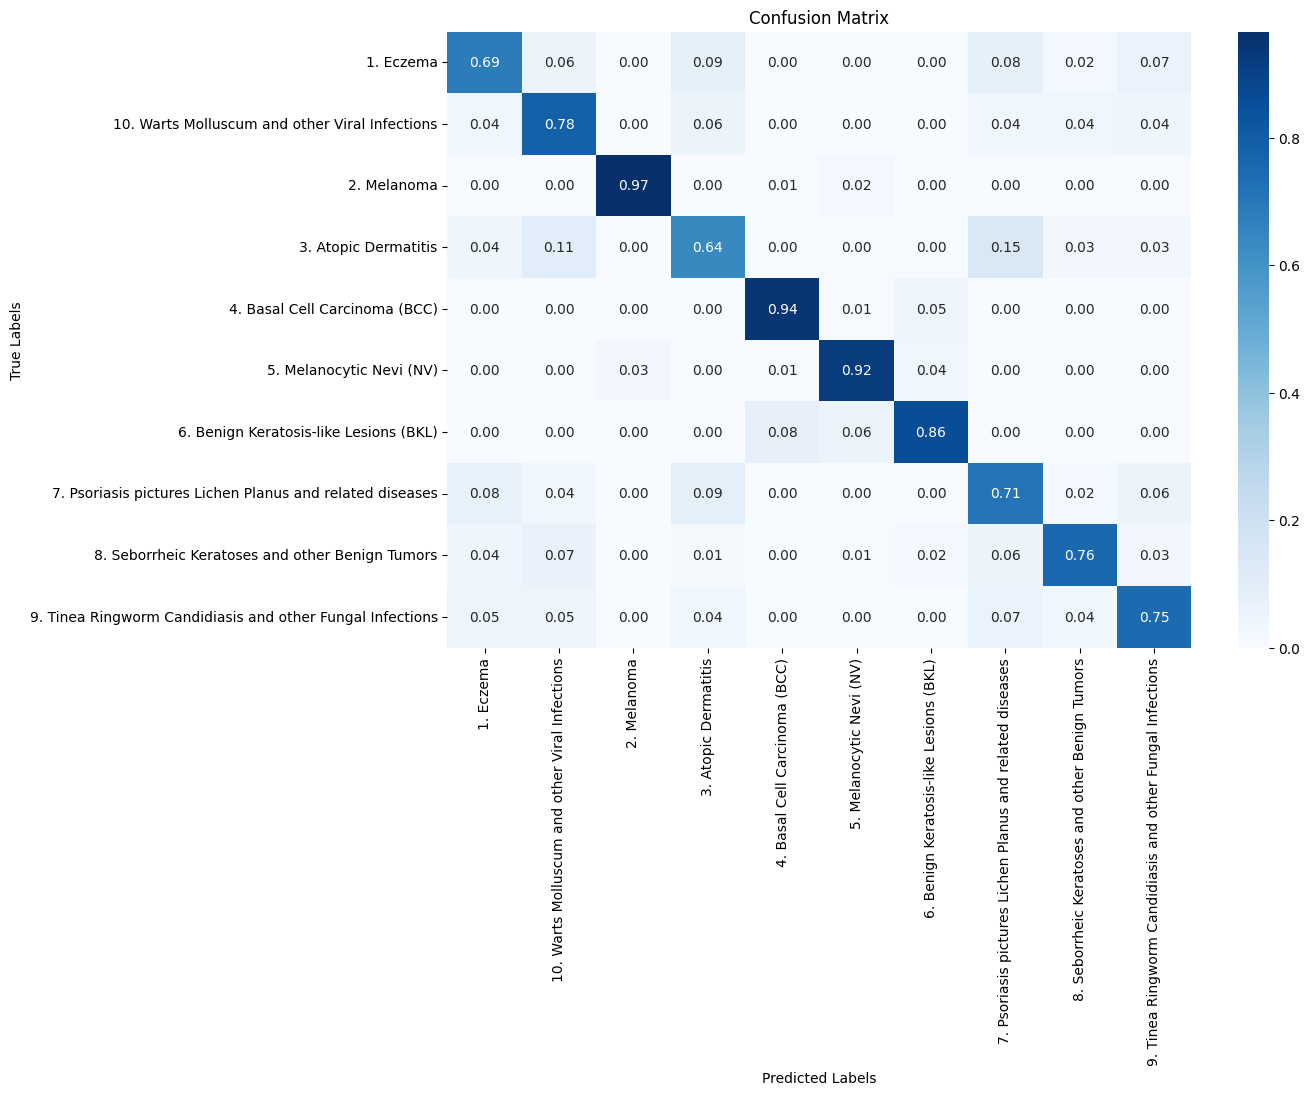

In [8]:
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [6]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.relu = nn.ReLU()
    
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)

        x += identity
        x = self.relu(x)

        return x


class ResNet50(pl.LightningModule):
    def __init__(self, ResBlock=Bottleneck, layer_list=[3,4,6,3], num_classes=10, num_channels=3):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
        scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        acc = (y_pred.argmax(dim=-1) == y).float().mean()
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        acc = (y_pred.argmax(dim=-1) == y).float().mean()
        self.log("val_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        acc = (y_pred.argmax(dim=-1) == y).float().mean()
        self.log("test_acc", acc)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50(num_classes=10).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
ResNet50                                 --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,160
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,928
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,640
│    │    └─BatchNorm2d: 3-6             512
│    │    └─Sequential: 3-7              17,152
│    │    └─ReLU: 3-8                    --
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,448
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,928
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [ ]:
wandb.init(project='skin_disease', name="training_resnet50_best", config={
    "learning_rate": 0.001,
    "batch_size": 64,
    "optim": "SGD",
    "epochs": 200
    }
)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  
    dirpath="/kaggle/working/",  
    filename="best_checkpoint"
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss", patience=10, mode="min"
)

wandb_logger = WandbLogger()
model = ResNet50(num_classes=10).to(device)
trainer = Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback, early_stopping_callback],  
    logger=wandb_logger 
)
trainer.fit(model, train_loader, val_loader)

In [13]:
trainer.test(model, dataloaders=test_loader)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7273395657539368     │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [9]:
checkpoint_path = "/kaggle/input/checkpoint-resnet50/checkpoint_0001_SGD.ckpt"
model = ResNet50.load_from_checkpoint(checkpoint_path, num_classes=10)
model.eval()

def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

all_preds, all_labels = evaluate_model(model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4)
print(report)

                                                           precision    recall  f1-score   support

                                                1. Eczema     0.4674    0.4896    0.4783       337
           10. Warts Molluscum and other Viral Infections     0.5150    0.6105    0.5587       421
                                              2. Melanoma     0.8792    0.9268    0.9023       628
                                     3. Atopic Dermatitis     0.4133    0.3676    0.3891       253
                            4. Basal Cell Carcinoma (BCC)     0.8411    0.8992    0.8692       665
                                 5. Melanocytic Nevi (NV)     0.9342    0.9003    0.9169      1594
                   6. Benign Keratosis-like Lesions (BKL)     0.7074    0.7074    0.7074       417
 7. Psoriasis pictures Lichen Planus and related diseases     0.4143    0.4515    0.4321       412
          8. Seborrheic Keratoses and other Benign Tumors     0.6698    0.5741    0.6183       371
9. Tinea 

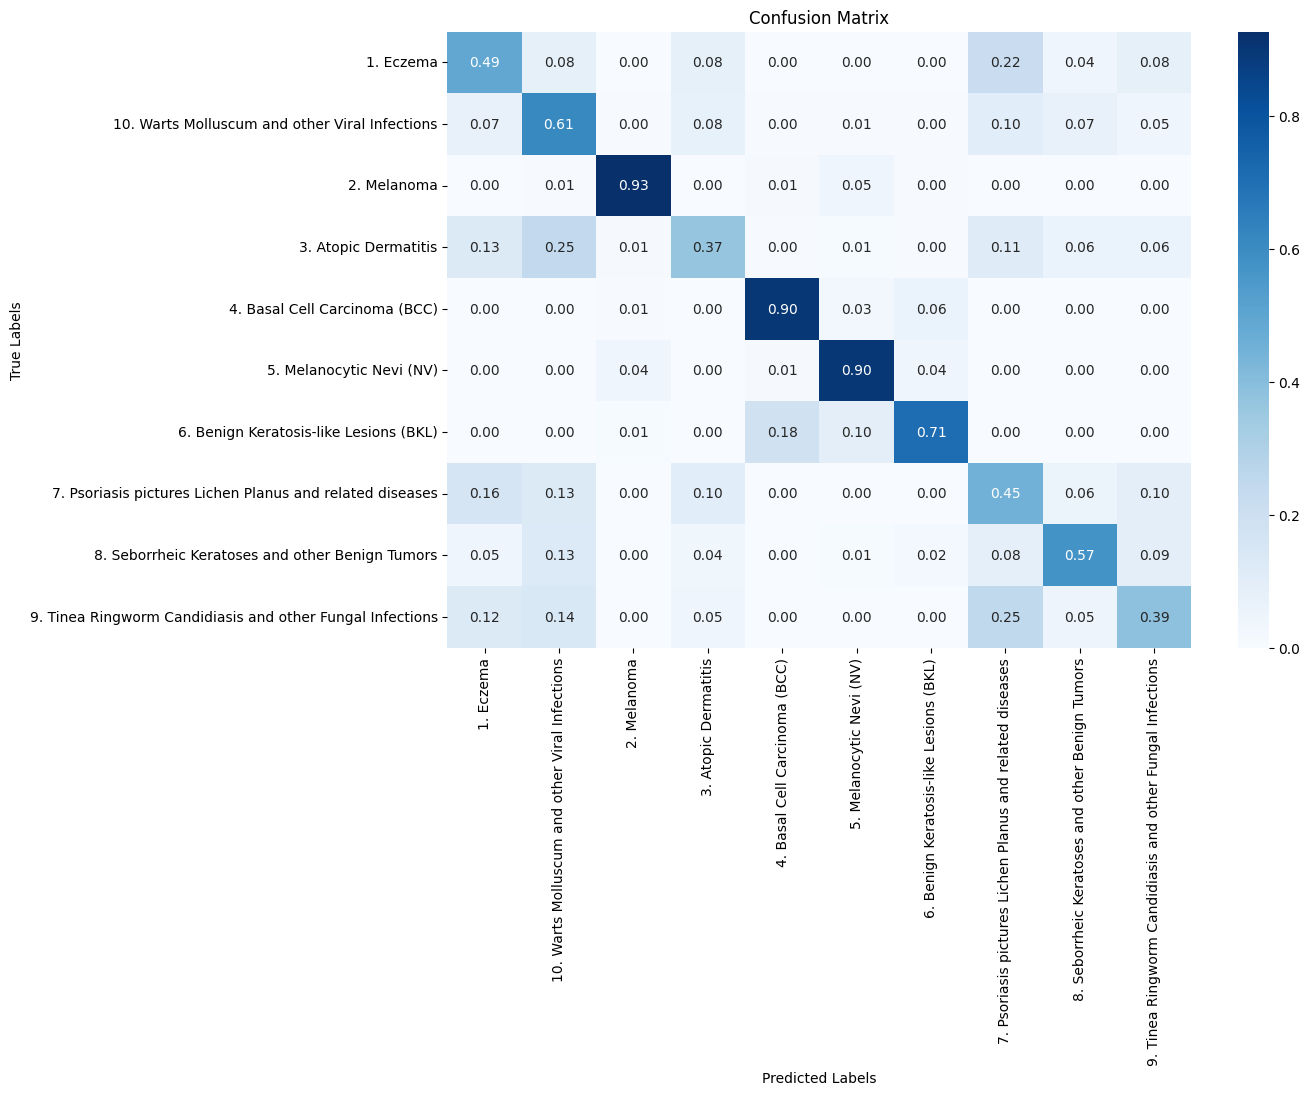

In [10]:
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()